# Project 3a: Hough Transform 

The purpose of this project is to acquaint you with the fundamental techniques behind two fundamental feature detection algorithms in Computer Vision: the Hough Transform and the Canny Filter.


In [1]:
import numpy as np
import cv2
from project3 import *
import matplotlib.pyplot as plt
import math
from utils import load_image, save_image
%matplotlib inline


# Part 1: Sobel Edge Detector


Congratulations!  You've unlocked the cv2.filter2d() method, which will replace the (non-linearly separable) filtering algorithms you created in Project 2.

Use it to implement a Sobel Edge detector.  As described in the textbook, the Sobel kernel finds oriented edges.    The kernel for finding vertical edges is:

$$ G_{x} = \begin{bmatrix} -1 & 0 & +1 \\ -2 & 0 & +2 \\ -1 & 0 & +1 \end{bmatrix}$$

and the kernel for finding horizontal edges is:

$$ G_{y} = \begin{bmatrix} -1 & -2 & -1 \\ 0 & 0 & 0 \\ +1 & +2 & +1 \end{bmatrix}$$

Using filter2d, run each of these kernels separately over some greyscale images, and show the results below.   How are the x and y gradients different?

Hint: I recommend *first* running a slight gaussian blur over an image to remove the worst high frequency noise.




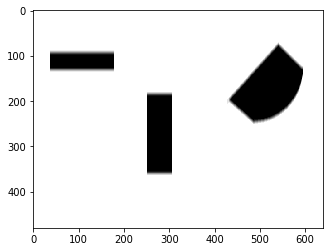

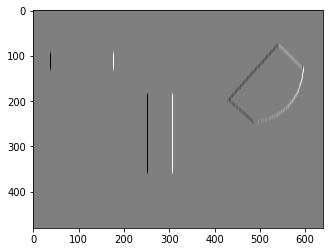

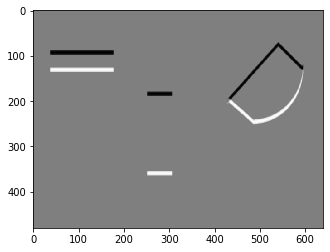

In [2]:
img = load_image("images/testimage.pgm")

# kernels
vertical_sobel = np.asarray([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
horizontal_sobel = np.asarray([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
gaussian = cv2.getGaussianKernel(ksize=10, sigma=5)

# blur image with Gaussian filter
img = cv2.filter2D(img, -1, gaussian)
plt.figure()
plt.imshow(img)

# normalize data to 0..1
v_dst = normalize_data(cv2.filter2D(img, -1, vertical_sobel))
h_dst = normalize_data(cv2.filter2D(img, -1, horizontal_sobel))

plt.figure()
plt.imshow(v_dst)
plt.figure()
plt.imshow(h_dst)


Of course, we're really presently only interested in the magnitude, not the orientation of edges (although that'll change soon), so we can use the following formula:

$G = \sqrt{G_{x}^{2} + G_{y}^{2}}$

In the cell below, show results of calculating the edge magnitude of the images you tested above

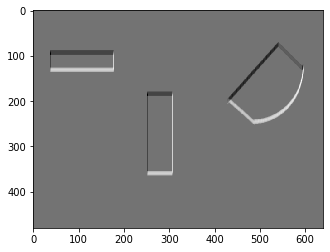

In [3]:
# calculate edge magnitudes and normalize them
magnitudes = get_edge_magnitudes(v_dst, h_dst)
plt.figure()
plt.imshow(normalize_data(magnitudes))

# Part 2: Hough Transform

Following Tuesday's lecture, recall that the Hough Transform is a way to find the predominant lines in an image (generally, a de-noised and edge-detected image).  It all revolves around using the equation:

$\rho = x*cos(\theta) + y*sin(\theta)$

to define a line.

Let's begin by "discretizing" our $\theta$ (angle) values into ten discrete values:


In [4]:
thetaVals = np.linspace(0,math.pi,9) #8 vals between 0 and pi


Then we can define a bunch of arbitrary points:

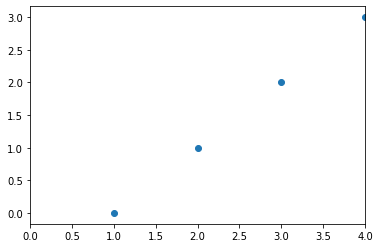

In [5]:
pt0 = (1,0)
pt1 = (2,1)
pt2 = (3,2)
pt3 = (4,3)
pts = [pt0,pt1,pt2,pt3]

xs = [p[0] for p in pts]
ys = [p[1] for p in pts]

plt.xlim(0,4)
plt.scatter(xs,ys)


Here's what we get for sweeping through the theta values described above, and finding each corresponding $\rho$ value:

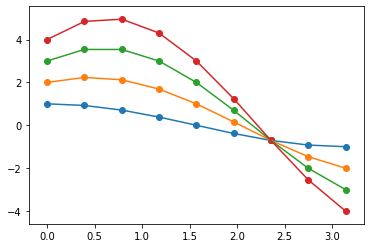

In [6]:
rhoVals = []
for p in pts:
    rhoVals = []
    for t in thetaVals:
        rhoVals.append(p[0]*math.cos(t) + p[1]*math.sin(t))
    #print(rhoVals)
    plot = plt.plot(thetaVals,rhoVals) 
    plot = plt.scatter(thetaVals,rhoVals) 
    

Notice that each point's $\rho$ values form a sinusoidal shape, and that all the shapes intersect at 3/4*$\pi$ (that is, 135 degrees).   What $\rho$ value do they intersect at?

Let's try a different set of points:

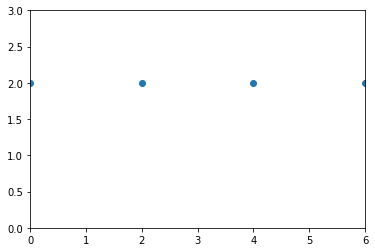

In [7]:
pt0 = (0,2)
pt1 = (2,2)
pt2 = (4,2)
pt3 = (6,2)
pts = [pt0,pt1,pt2,pt3]

xs = [p[0] for p in pts]
ys = [p[1] for p in pts]

plt.xlim(0,6)
plt.ylim(0,3)
plt.scatter(xs,ys)

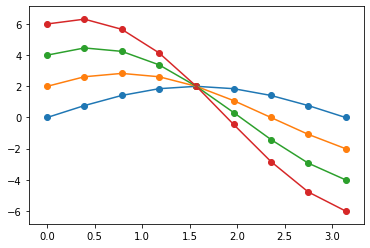

In [8]:

rhoVals = []
for p in pts:
    rhoVals = []
    for t in thetaVals:
        rhoVals.append(p[0]*math.cos(t) + p[1]*math.sin(t))
    #print(rhoVals)
    plot = plt.plot(thetaVals,rhoVals) 
    plot = plt.scatter(thetaVals,rhoVals) 

--- 
And this is what it looks like whe nwe have *two dominant lines in an image.

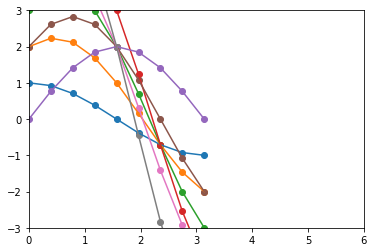

In [9]:
pt0 = (1,0)
pt1 = (2,1)
pt2 = (3,2)
pt3 = (4,3)
pt10 = (0,2)
pt11 = (2,2)
pt12 = (4,2)
pt13 = (6,2)
pts = [pt0,pt1,pt2,pt3,pt10,pt11,pt12,pt13]

plt.xlim(0,6)
plt.ylim(-3,3)
#plt.scatter(xs,ys)


rhoVals = []
for p in pts:
    rhoVals = []
    for t in thetaVals:
        rhoVals.append(p[0]*math.cos(t) + p[1]*math.sin(t))
    #print(rhoVals)
    plot = plt.plot(thetaVals,rhoVals) 
    plot = plt.scatter(thetaVals,rhoVals) 

## Part 1: The Hough Transform

Now that you understand how the Hough Transform works, try to replicate (by hand) the OpenCV Hough Transform function using an function signature.

The Hough Transform, as covered in class, is an algorithm where each non-zero pixel in an image (typically an edge-detected, thresholded image) "votes" for every line in might belong to.  In the above examples, we've discretized the angles that our lines could belong to into eight possible $\theta$ values, and then calculated $\rho$ for each point for each theta value.  In both examples above, all for points agree they belong to the same line.  

The Hough Transform, then, takes in a set of points, and returns a set of lines.  Following the [openCV API]( https://docs.opencv.org/2.4/modules/imgproc/doc/feature_detection.html?highlight=houghlines), the Hough transform method should take the following form: 

lines = cv2.HoughLines(image, rho, theta, threshold)

That is, it should return an output vector of lines whose "votes" exceed the provided vote threshold.  Each line is represented by a two-element vector ($\rho$, $\theta$). Read the API to understand the units of the rho and theta arguments.






In [10]:
#from project3 import *
#load an image
#lines = myHoughLines()